<a href="https://colab.research.google.com/github/ritwiks9635/Image-Similarity-/blob/main/Image_Similarity_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Similarity Estimation**

In [ ]:
!pip install tensorflow --upgrade
!pip install keras --upgrade

In [2]:
import os
import random
import numpy as np
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, ops

import matplotlib.pyplot as plt

In [3]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [ ]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

In [5]:
img_size = (200, 200)

def preprocess_input(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, img_size)
    return image


def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_input(anchor),
        preprocess_input(positive),
        preprocess_input(negative)
    )

In [6]:
anchor_images = sorted([str(anchor_images_path / x) for x in os.listdir(anchor_images_path)])

positive_images = sorted([str(positive_images_path / x) for x in os.listdir(positive_images_path)])

total_images = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

rng = np.random.RandomState(42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size = 4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size = 1024)
dataset = dataset.map(preprocess_triplets)

train_dataset = dataset.take(round(total_images * 0.8))
valid_dataset = dataset.skip(round(total_images * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder = False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.batch(32, drop_remainder = False)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

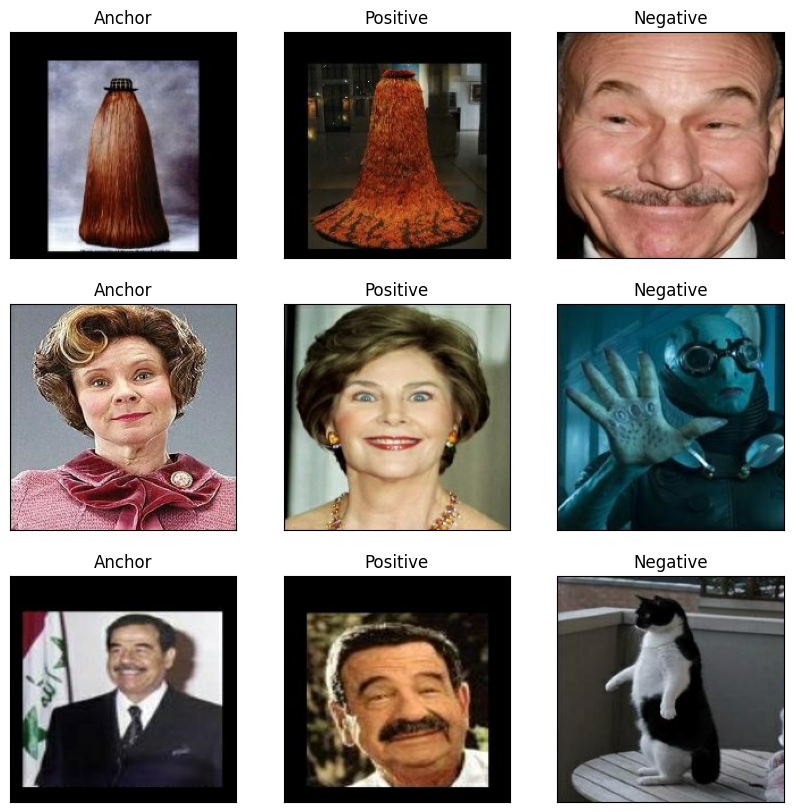

In [7]:
def show_data(anchor, positive, negative):
    def show(ax, img, name = ""):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(name)

    fig = plt.figure(figsize=(10,10))
    ax = fig.subplots(3, 3)

    for i in range(3):
        show(ax[i, 0], anchor[i], name = "Anchor")
        show(ax[i, 1], positive[i], name = "Positive")
        show(ax[i, 2], negative[i], name = "Negative")


show_data(*list(train_dataset.take(1).as_numpy_iterator())[0])

## **Embedding generator model**
Our Siamese Network will generate embeddings for each of the images of the triplet. To do this, we will use a ResNet50 model pretrained on ImageNet and connect a few Dense layers to it so we can learn to separate these embeddings.

In [8]:
base_model = keras.applications.ResNet50(
    weights = "imagenet", input_shape = img_size + (3,), include_top = False)

fl = layers.Flatten()(base_model.output)
de1 = layers.Dense(512, activation = "relu")(fl)
ba1 = layers.BatchNormalization()(de1)
de2 = layers.Dense(256, activation = "relu")(ba1)
ba2 = layers.BatchNormalization()(de2)
outputs = layers.Dense(256)(ba2)

embeddings = keras.Model(base_model.input, outputs, name = "embedding")

trainable = False
for layer in base_model.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **Siamese Network model**
The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

In [9]:
class Distance_layer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        a_p_distance = ops.sum(tf.square(anchor - positive), -1)
        a_n_distance = ops.sum(tf.square(anchor - negative), -1)
        return (a_p_distance, a_n_distance)


anchor_input = layers.Input(name = "anchor_input", shape = img_size + (3,))
positive_input = layers.Input(name = "positive_input", shape = img_size + (3,))
negative_input = layers.Input(name = "negative_input", shape = img_size + (3,))

distance_output = Distance_layer()(
    embeddings(keras.applications.resnet.preprocess_input(anchor_input)),
    embeddings(keras.applications.resnet.preprocess_input(positive_input)),
    embeddings(keras.applications.resnet.preprocess_input(negative_input))
    )

siamese_network = keras.Model(
    inputs = [anchor_input, positive_input, negative_input], outputs = distance_output)

## **Putting everything together**

We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.

In [10]:
class SiameseModel(keras.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [11]:
model = SiameseModel(siamese_network)
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001))
model.fit(
    train_dataset,
    epochs = 10,
    validation_data = valid_dataset)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 119s 550ms/step - loss: 0.7265 - val_loss: 0.3791
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 60s 401ms/step - loss: 0.4024 - val_loss: 0.3557
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 81s 394ms/step - loss: 0.3571 - val_loss: 0.3378
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 64s 425ms/step - loss: 0.3543 - val_loss: 0.3418
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 61s 405ms/step - loss: 0.3234 - val_loss: 0.3319
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 81s 398ms/step - loss: 0.3256 - val_loss: 0.3074
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 61s 403ms/step - loss: 0.3081 - val_loss: 0.3403
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 61s 403ms/step - loss: 0.2930 - val_loss: 0.3104
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 60s 395ms/step - loss: 0.2935 - val_loss: 0.3051
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 64s 427ms/step - loss: 0.2873 - val_loss: 0.3088


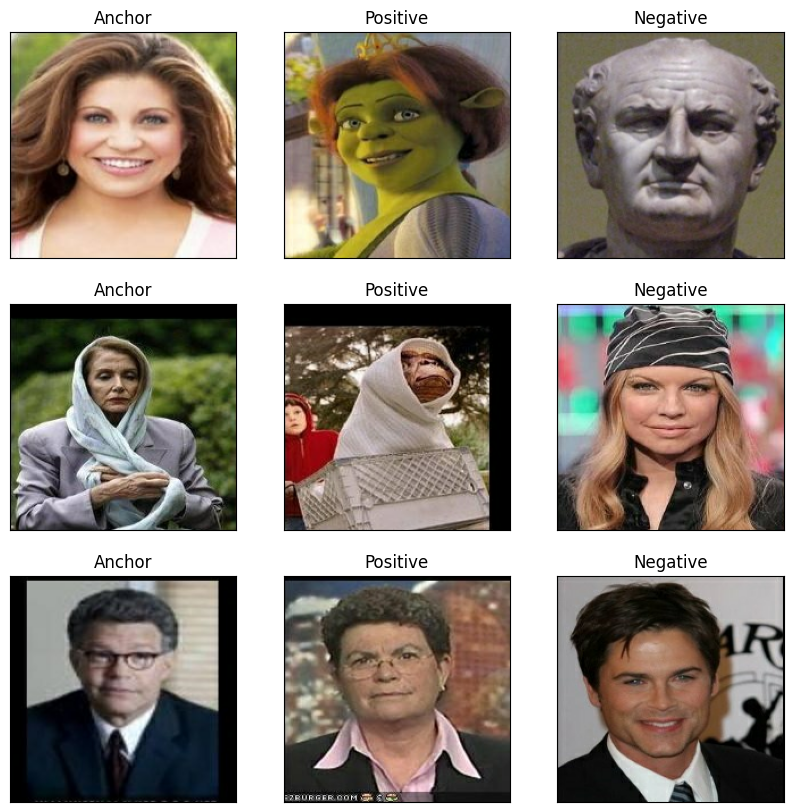

In [13]:
sample = next(iter(train_dataset))
show_data(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embeddings(keras.applications.resnet.preprocess_input(anchor)),
    embeddings(keras.applications.resnet.preprocess_input(positive)),
    embeddings(keras.applications.resnet.preprocess_input(negative)),
)

In [16]:
cosine_similarity = keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity : ", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity : ", negative_similarity.numpy())

Positive similarity :  0.99523324
Negative similarity :  0.9935596
